## Лабораторна робота №2 “EDA and Supervised Learning”

<b>Мета</b>: навчитись робити розвідку даних (Exploratory Data Analysis - EDA) та використовувати інструменти для моделювання при навчанні з вчителем (Supervised Learning).

### Завдання

4. Побудувати класифікатор на основі проаналізованих даних. Дозволяється
використати будь-який з відомих Вам методів (наприклад за допомогою https://scikitlearn.org/stable/supervised_learning.html). Для оцінки якості натренованої моделі
використати train-val-split, тобто відкласти частину “application_train.csv” для
валідації. Метрика - ROC_AUC.
5. Класифікувати дані з файла application_test.csv, записати результат в submission
файл за прикладом “sample_submission.csv”.
6. Залити submission файл на платформу в “Leaderboard”->“Late Submission”, отримати
результат - оцінку, зробити знімок екрану і додати його до фінального ноутбука.

## Хід виконання

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import sklearn.preprocessing as prep
import warnings
import logging
import sklearn.covariance as cov
from scipy.stats import chi2
from itertools import product
import seaborn as sns
import random
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import sys
from lightgbm import LGBMClassifier

# отключение логгеров и предупреждений
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').disabled = True
log = logging.getLogger()
log.setLevel(logging.CRITICAL)

In [2]:
cleaned_data = pd.read_pickle('cleaned_data.pkl')

In [3]:
cleaned_data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283799 entries, 0 to 304530
Columns: 69 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: category(52), float64(13), int64(4)
memory usage: 53.0 MB


In [4]:
cleaned_data.reset_index(drop=True, inplace=True)

### Вибір моделі

In [5]:
# поділ на numpy arrays, розділення метричних та категорійних змінних
y = cleaned_data[['TARGET']].values
X = cleaned_data.drop(columns=['TARGET'])
metric_X = X.loc[:,(np.array(X.dtypes == "float64")) | (np.array(X.dtypes == "int64"))].copy()
non_metric_X = X.loc[:,(np.array(X.dtypes != "float64")) | (np.array(X.dtypes != "int64"))].copy()

In [6]:
# перетворення категорій на числові мітки
le = LabelEncoder()
for col in non_metric_X:
    non_metric_X[col] = le.fit_transform(non_metric_X[col])

In [7]:
# об'єднання таблиці
X = metric_X.merge(non_metric_X, left_index=True, right_index=True)

In [8]:
# отримання стандартних значень
se = StandardScaler()
X = se.fit_transform(X)

### Вибір моделі за найвищим roc_auc_score

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [34]:
# logistic regression
clf = LogisticRegression(random_state=0, C = 0.001, n_jobs=6)
clf.fit(X_train, y_train)
print('{}: {}'.format(clf, roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))

LogisticRegression(C=0.001, n_jobs=6, random_state=0): 0.7366712951205698


In [35]:
# XGBoost
clf = xgb.XGBClassifier(n_jobs=6, verbosity=0)
clf.fit(X_train, y_train, verbose=False, early_stopping_rounds=100, eval_metric="auc",
        eval_set=[(X_test, y_test)])
print('{}: {}'.format(clf, roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0): 0.7411445405959807


In [39]:
#LGBMClassifier
clf = LGBMClassifier(n_jobs = 6)
clf.fit(X_train, y_train)
print('{}: {}'.format(clf, roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))

LGBMClassifier(n_jobs=6): 0.744799894282409


### Підготовка датафрейма для передбачення

In [40]:
df_test = pd.read_csv('test_data.csv')
df_test = df_test[cleaned_data.drop(columns=['TARGET']).columns].copy()
df_test.head(3)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,F,N,Y,135000.0,568800.0,Unaccompanied,Working,Higher education,Married,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cash loans,M,N,Y,99000.0,222768.0,Unaccompanied,Working,Secondary / secondary special,Married,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,Cash loans,M,Y,Y,202500.0,663264.0,NaN,Working,Higher education,Married,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


In [41]:
df_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 68 entries, NAME_CONTRACT_TYPE to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(18), int64(38), object(12)
memory usage: 25.3+ MB


In [42]:
col_lst = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE',
           'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
           'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

for col in col_lst:
    df_test[col].fillna(0, inplace=True)

In [43]:
df_test['NAME_TYPE_SUITE'].fillna('Unaccompanied', inplace=True)
df_test['OCCUPATION_TYPE'].fillna('Not defined', inplace=True)

In [44]:
df_test.isna().sum().loc[df_test.isna().sum() > 0].sort_values(ascending=True)

Series([], dtype: int64)

In [45]:
categ = pd.read_pickle('cat.pkl')
for col in df_test.columns:
    df_test[col] = df_test[col].astype(categ.at[col, 0])
X = df_test

In [46]:
metric_X = X.loc[:,(np.array(X.dtypes == "float64")) | (np.array(X.dtypes == "int64"))].copy()
non_metric_X = X.loc[:,(np.array(X.dtypes != "float64")) | (np.array(X.dtypes != "int64"))].copy()
le = LabelEncoder()
for col in non_metric_X:
    non_metric_X[col] = le.fit_transform(non_metric_X[col])

In [47]:
X = metric_X.merge(non_metric_X, left_index=True, right_index=True)
se = StandardScaler()
X = se.fit_transform(X)

In [48]:
X.shape

(48744, 85)

### Формування передбачення

In [49]:
y = clf.predict_proba(X)[:,1]

### Підготовка даних для експорту

In [50]:
df_test = pd.read_csv('test_data.csv')
ids = df_test['SK_ID_CURR']
pd.DataFrame({'SK_ID_CURR': ids, 'TARGET': y.ravel()}).to_csv('subm.csv', index=False)

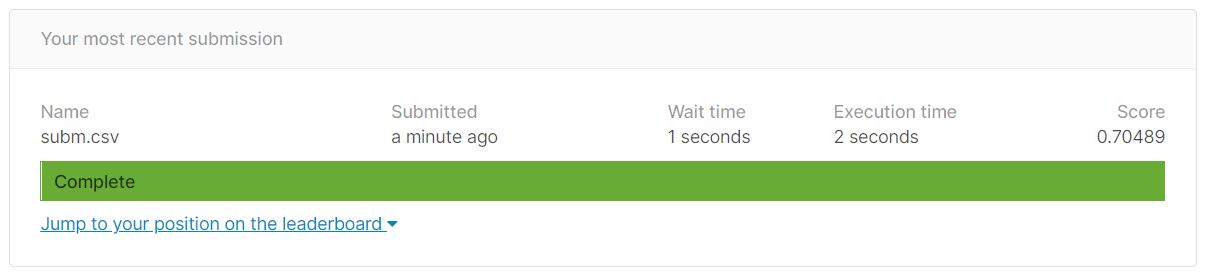